# PART B: UNSUPERVISED LEARNING (50 marks)


Background


You are running a shopping mall, and you have some data about your customers like
Age, Gender, Income and Spending.


By the end of this study, you would be able to answer below questions.


- How to perform customer segmentation using unsupervised machine learning
algorithm in Python?
- Describe the characteristics of each customer cluster.
- Which group of customer is the most valuable to the shopping mall so that the
shopping mall should do something to retain them.


Dataset


Use the Customer_dataset.csv


Tasks
1. Write the code to solve the clustering task. Use scikit-learn only (do not use
other 3rd party libraries).
2. Write a short report detailing your implementation, your experiments and
analysis in the Jupyter notebook (along with your python code and
comments).
3. Test your clustering with different possible values of k.
4. Determine the best possible value of k. And show how you are able to
determine that this is the best value for k.
5. Use more than just one clustering (k-means) algorithm.
6. Create a set slides with the highlights of your Jupyter notebook. Explain
the unsupervised machine learning process, model building and
evaluation. Write your conclusions.


# Data Exploration 

## Reading Dataset
The Customer dataset contains 4 useful attributes and 200 records. The ultimate task of this dataset is to perform clustering and devise a feasible strategy to increase the mall's profit by gaining a better understanding on the customer demographic.
### Data Dictionary
| Columns | Descriptions |
| :--     | :--          |
| Gender | Gender of customer |
| Age | Age of the customer |
| Income (k$) | Annual Income of the customer |
| How Much They Spend | Scoring from 0-100 based on spending activity (?) |


## Data Analysis

We can Perform EDA on the data to further our understanding on this data

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from itertools import combinations, chain
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.decomposition import PCA

In [3]:
#set the style for the plots
sns.set_style('darkgrid')

#set the size of the plots
plt.rcParams['figure.figsize'] = (15, 8)


In [4]:
initialdata = pd.read_csv('data/Customer_Dataset.csv')

initialdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
initialdata.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Initial insights 

From the basic data visualization functions, we can already pick up on some of the characteristics of the data. 

1. There does not seem to be any null values

2. There is a redundant column, CustomerID

3. Most data is numerical

General structure of data:

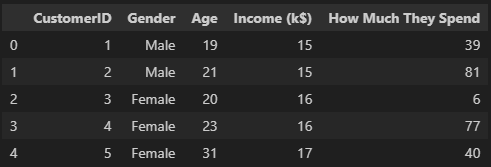

Now that the basic overview of the data in complete, we can perform a more thorough analysis on the data and identify certain attributes such as outliers and distributions

### Non-Numerical/Categorical Data 


From the initial analysis, we can identify that there is only one Non-Numerical/Categorical column, Gender. For this kind of data, we can look into the distribution of the data.

Distribution of Data: 
Female    112
Male       88
Name: Gender, dtype: int64


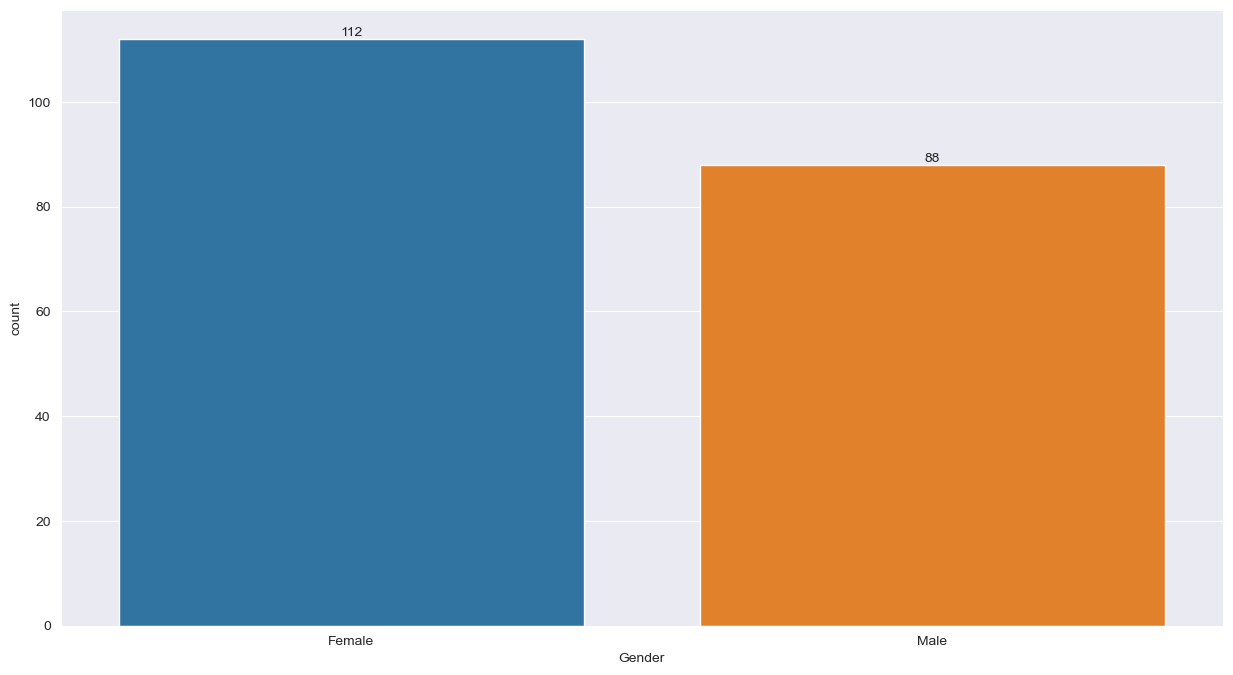

In [6]:
#Unique value count of 'Gender' Column
counts = initialdata["Gender"].value_counts()
print(f'Distribution of Data: \n{initialdata["Gender"].value_counts()}')

# plot the distribution of each categorical variable
ax = sns.countplot(x='Gender', data=initialdata, order=counts.index)
for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

#### Categorical Data Distribution 

We can see that there are is a considerable difference between the two genders. There are more females compared to males, however this does not affect the clustering in a significant manner as the difference is not too extreme, therefore we can skip and preprocessing to address this uneven distribution for now.

### Numerical Data 

For Numerical Data, we can check for outliers as well as the distribution of the data.

In [7]:
# Firstly we can drop the "CustomerID" column as it is not required for clustering

initialdata.drop('CustomerID', axis=1, inplace=True)

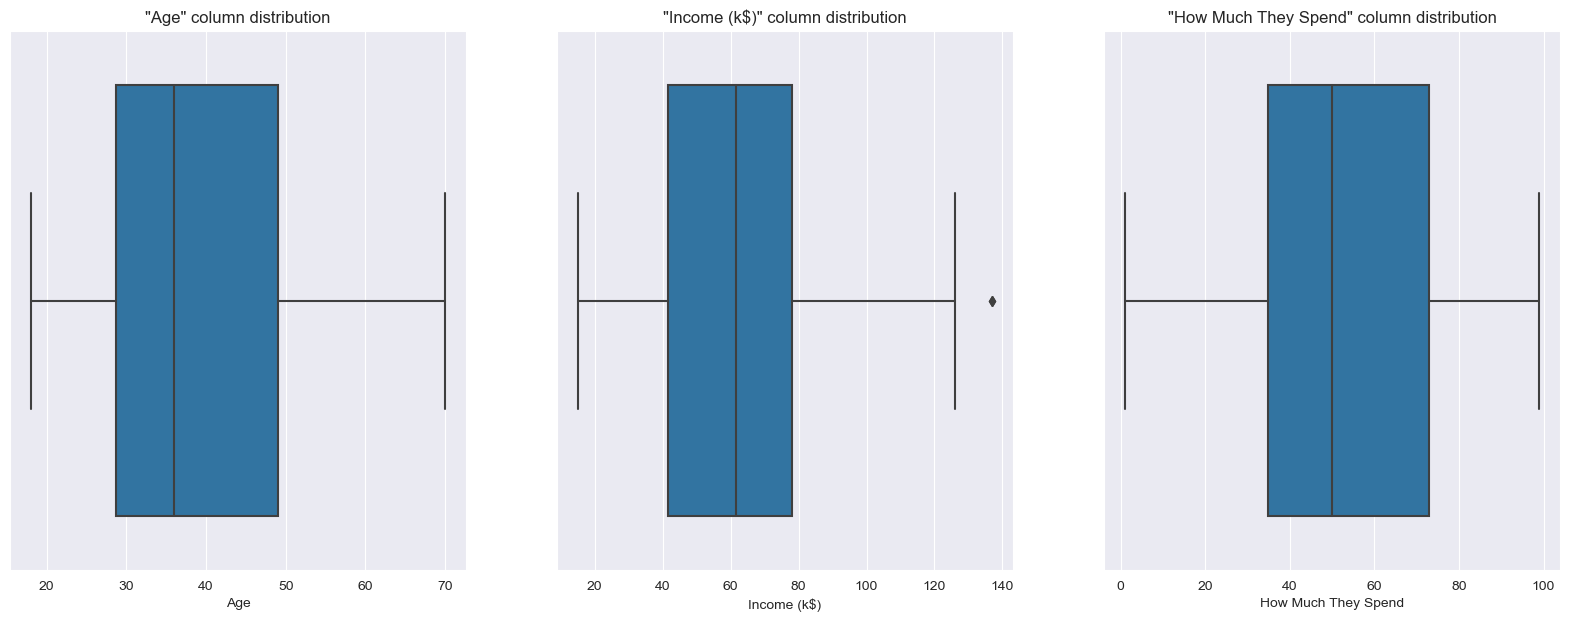

In [8]:
# Identify Outliers in the data
numerical_cols = ['Age', 'Income (k$)', 'How Much They Spend']
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x = col, data = initialdata, ax = ax[i])
    ax[i].set_title(f'"{col}" column distribution')

plt.show()

#### Boxplot 

From this Boxplot we can see that there are no extreme outliers, so we no preprocessing will be neccessary. It can also be seen that the data seems to be slightly skewed, to gain a better visualization on this, we can use a histogram plot

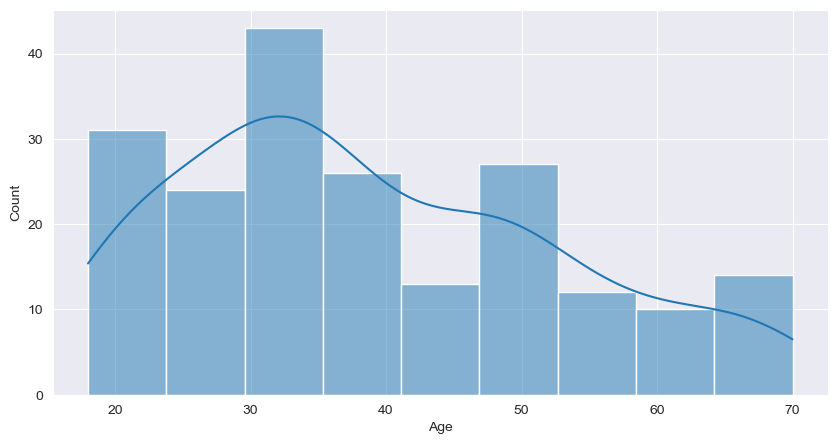

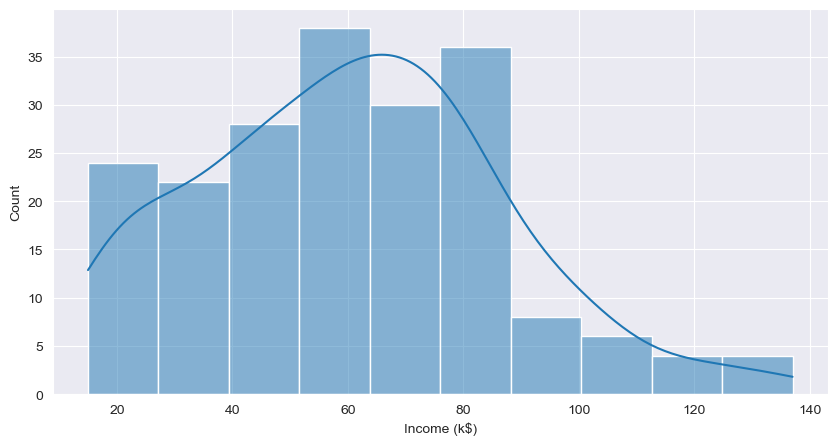

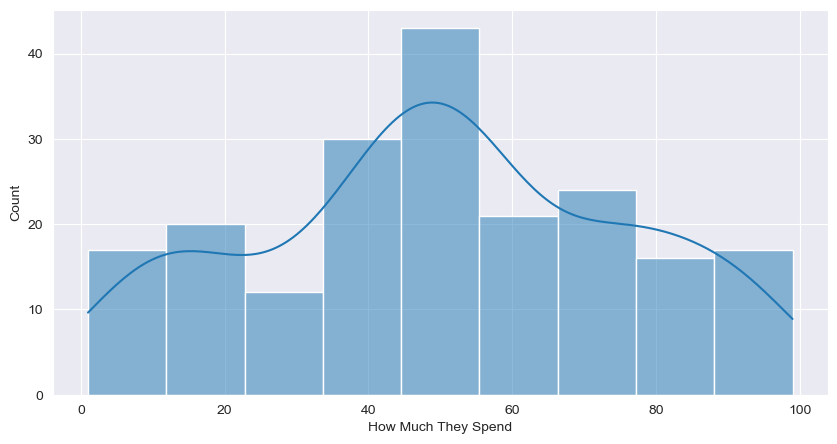

In [9]:
# Histogram to check distribution of data

for i in numerical_cols:
    plt.figure(figsize=(10,5))
    sns.histplot(initialdata[i], kde = True)
    plt.show()

#### Histogram

There does not seem to be any significant skewness in the distribution of the data, however to further improve the performance of certain models, we can still consider normalizing the data (preprocessing part).

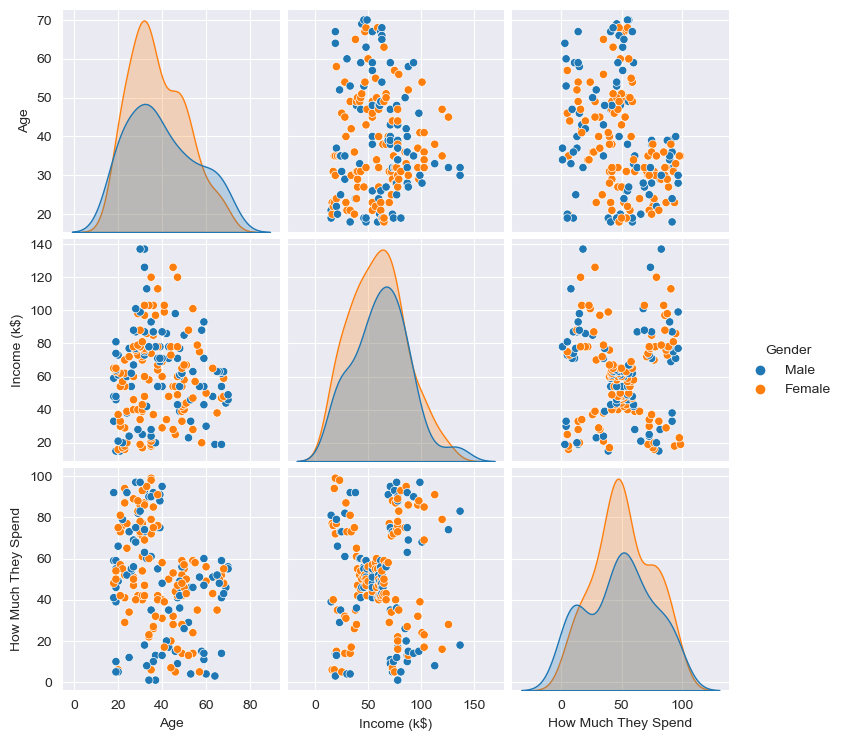

In [10]:
# pair plot
sns.pairplot(initialdata, diag_kind='kde', hue = 'Gender')
plt.show()

#### Pair Plot

Since our feature space is not large, we can use a Pairplot to visualise the distribution of datapoints, categorised by the gender, this will allow us to identify the following attributes of the data:

1. Firstly from the general pairplot, we might already be able to **identify clusters** straight away
2. Can we identify any **difference in the distribution** of data for each feature **based off of gender**


##### Evaluation
1. The mean Spending Score for females appears to be higher than that of males. However, upon analyzing scatterplots, the distribution of data points for both genders seems random across each feature. This suggests that there might not be a significant difference in spending habits between males and females, even though the mean scores might differ.

2. **Clusters are somwhat identifiable** for the **How much they spend** and **Income (k$)** feature, however **Age** does not show any identifiable clusters. This might pose a challenge for clustering algorithms to effectively group data points based on age, however exploring how age interacts with or influences other attributes might reveal patterns that aren't immediately evident so we do not need to worry for now


#### Correlation Heatmap

From the pairplot we can see that there might not be any strong correlation between each feature, however it is not a bad idea to still perform a correlation plot to possibly identify any underlying relations between the features.

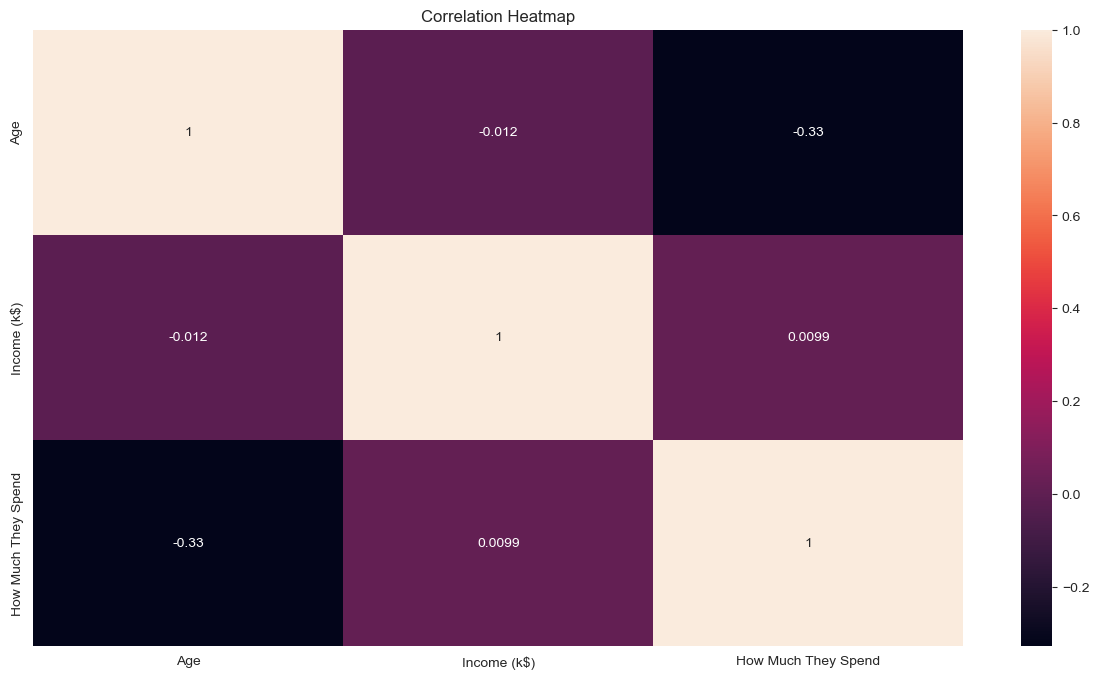

In [11]:
sns.heatmap(initialdata.corr(), annot= True)
plt.title("Correlation Heatmap")
plt.show()

#### Evaluation

1. There's **no linear relationship** between **Age** and **Income (k$)**.
2. There's a **moderate negative correlation** between **Age and How Much They Spend**, implying that older individuals tend to spend slightly less.
3. There's **no linear relationship** between **Income(k$)** and **How Much They Spend**.

Although the scores low, we have to keep in mind that correlation coefficients can only capture linear relationships, and there might be non-linear associations that aren't reflected in these values. Additionally, a correlation coefficient close to zero doesn't necessarily mean that there's no relationship, we have to keep in mind non-linear or complex relationships not captured by linear correlation.

### Preprocessing

For this dataset, not much preprocessing is needed, however as the numerical columns do not have the same units, we should scale the data, in this case powertransformer is used as some models assume normality, so we should make the data normal. We can also convert the categorical column (Gender) into numerical columns using get dummies (One Hot Encoding kind of)

In [12]:
data_scaled = initialdata[["Age","Income (k$)","How Much They Spend"]]

scaler = PowerTransformer()
data_scaled = scaler.fit_transform(data_scaled)
initialdata[["Age","Income (k$)","How Much They Spend"]] = data_scaled

initialdata = pd.get_dummies(initialdata, columns=['Gender'], drop_first=True)


#### PCA Analysis

Due to the ambiguous state of the data, it might be wise to remove any unneccessary columns in an attempt to uncomplicate the data. This is where PCA comes in, PCA is a dimensionality reduction technique, that simplifies complex data by finding the most important patterns or features, called principal components, and transforming the data into a new coordinate system aligned with these components. With this we can reduce the data's dimensionality in order to try and uncomplicate the data while retaining as much relevant information as possible.

In [13]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, components], axis = 1)

In [14]:
pca = PCA(n_components=3).fit(initialdata.drop(columns=['Gender_Male']))
pca_samples = pca.transform(initialdata.drop(columns=['Gender_Male']))

pca_result = pca_results(initialdata.drop(columns=['Gender_Male']), pca)
pca_result

,Eigenvalue,Explained Variance,Age,Income (k$),How Much They Spend
PC 1,1.3200,0.4378,-0.7080,-0.1062,0.6982
PC 2,1.0067,0.3339,0.0154,0.9861,0.1656
PC 3,0.6884,0.2283,-0.7061,0.1280,-0.6965


##### PCA Evaluation

In our PCA analysis, it's evident that even the component with the lowest explained variance, PC3, contributes significantly to the overall understanding of the data. With a contribution of 0.2283 to the total explained variance, dropping PC3 would lead us to fall short of our desired threshold of 80% explained variance. As a result, the decision is to retain all principal components for a comprehensive representation of the data.

By retaining all components, we ensure that each facet of the data's variance is taken into account, maintaining a robust and insightful understanding of the underlying patterns within the dataset.

# Modelling

We can now fit a simple K means model to start, K means is a centroid based clustering algorithm as well as one of the most basic and popular clustering algorithms.

In [15]:
#to gain a general understanding on how good a model can fit the data, we can use a arbitrary K means clustering model
#Note that kmeans does not take in CATEGORICAL data, so we will only be using the NUMERICAl data

kmeansmodel = KMeans(n_clusters=3, random_state=0)
kmeansmodel.fit(initialdata)

KMeans(n_clusters=3, random_state=0)

## Model Evaluation


For Evaluation, i will be using the following metrics:






### Silhouette Score:

The Silhouette score is a clustering evaluation metric that quantifies **how well each data point fits into its assigned cluster** and how distinct the clusters are from each other. It measures the similarity of an object to its own cluster compared to other clusters.

``To calculate the Silhouette score for a single data point:``
1. Compute the average distance between the data point and all other points within the same cluster (intra-cluster distance, 'a').
2. Compute the average distance between the data point and all points in the nearest neighboring cluster (inter-cluster distance, 'b').
3. Calculate the Silhouette score for the data point as ``(b - a) / max(a, b)``.

The overall Silhouette score for a clustering result is the average of the Silhouette scores for all data points. It provides a value between -1 and 1, where:
- A score close to **+1** indicates that the data point is **well-clustered** and distant from other clusters, suggesting well-defined clusters.
- A score around **0** indicates overlapping or **ambiguous** clusters.
- A score close to **-1** suggests that the data point might have been assigned to the **wrong cluster**.

A **higher** Silhouette score indicates **better-defined** and **well-separated** clusters, making it a useful criterion to guide model selection and optimization.






### Davies-Bouldin Index:

The Davies-Bouldin Index is yet another clustering evaluation metric that measures the average similarity between each cluster and its most similar cluster, considering both within-cluster and between-cluster distances.

``To calculate the Davies-Bouldin Index:``

1. Compute the average distance between each data point in a cluster and the cluster center (within-cluster distance).
2. Compute the average distance between each pair of cluster centers (between-cluster distance).
3. For each cluster, calculate the Davies-Bouldin Index as the average of the ``(within-cluster distance + between-cluster distance)`` ratios with its most similar cluster.
4. The overall Davies-Bouldin Index is the average of the indices for all clusters.

A **lower Davies-Bouldin Index** indicates **better clustering**, with well-separated and distinct clusters having smaller index values.





### Calinski-Harabasz Index:

The Calinski-Harabasz Index is another clustering evaluation metric used to assess the quality of clustering results. It measures the ratio of the between-cluster dispersion to the within-cluster dispersion.

``To calculate the Calinski-Harabasz Index:``

1. Compute the average distance between each data point and its cluster center (intra-cluster dispersion).
2. Compute the average distance between each cluster center and the overall data centroid (inter-cluster dispersion).
3. Calculate the Calinski-Harabasz Index as ``(inter-cluster dispersion / intra-cluster dispersion) * (n_samples - k) / (k - 1)``, where:
   - **n_samples**: Total number of data points.
   - **k**: Number of clusters.

The Calinski-Harabasz Index yields a higher value for well-separated and compact clusters, making it a useful metric for evaluating clustering algorithms. A **higher index value** indicates **better-defined and more distinct clusters**.








In [16]:
# evaluate the clustering results

labels = kmeansmodel.labels_
silhouette = silhouette_score(initialdata, labels)
print("Silhouette Score:", silhouette)

db_score = davies_bouldin_score(initialdata, labels)
print("Davies Bouldin Score:", db_score)

ch_score = calinski_harabasz_score(initialdata, labels)
print("Calinski Harabasz Score:", ch_score)

scoring_df = pd.DataFrame({'Model' : 'K means','Silhouette Score': [silhouette], 'Davies Bouldin Score': [db_score], 'Calinski Harabasz Score': [ch_score],'Params': 'Base Arbi K'})

Silhouette Score: 0.3162991648510382
Davies Bouldin Score: 1.136648997252179
Calinski Harabasz Score: 88.33457260217897


### Base model Eval:
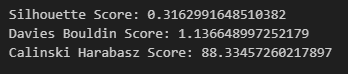

Recall the grading criteria from the previous markdown, silhouette score ranges from -1 to 1, where a higher score means a better fit,calinski Harabasz index and davies bouldin index does not have an upper limit and is relative so we cannot use this metric for comparison until we tune another model.

We can evaluate the model off of the silhouette score first, the silhouette score of 0.31630 (5sf) suggests a moderately good fit for the clustering model. It indicates that the data points in the clusters are relatively closer to each other than to points in other clusters. However, there is still room for improvement to achieve a better clustering.

## Enhancing k means clustering

To make our k means clustering model better, we can tweak it in a number of ways to improve its performance and effectiveness in grouping data points. 

### Elbow Plot and Silhouette Score

Elbow Method is used to identify which $k$ terms causes **Inertia to drops most significantly as compared to inertia before**. This point can be identified to be the optimal K term.

Inertia Measure the Sum of Squared Distance of each datapoints to its assigned cluster centroids.This helps you know if the points are close to the centroid or if they're too spread out.

**Explanation:**
- With $k$ increase, the inertia will decrease. This is because with more clusters being formed, each datapoints will be closer to its centroids. However, this come at the cost of interpretability of the cluster formed with high number of $k$
- The "Elbow" might not be visible if the clustering is ambiguous.

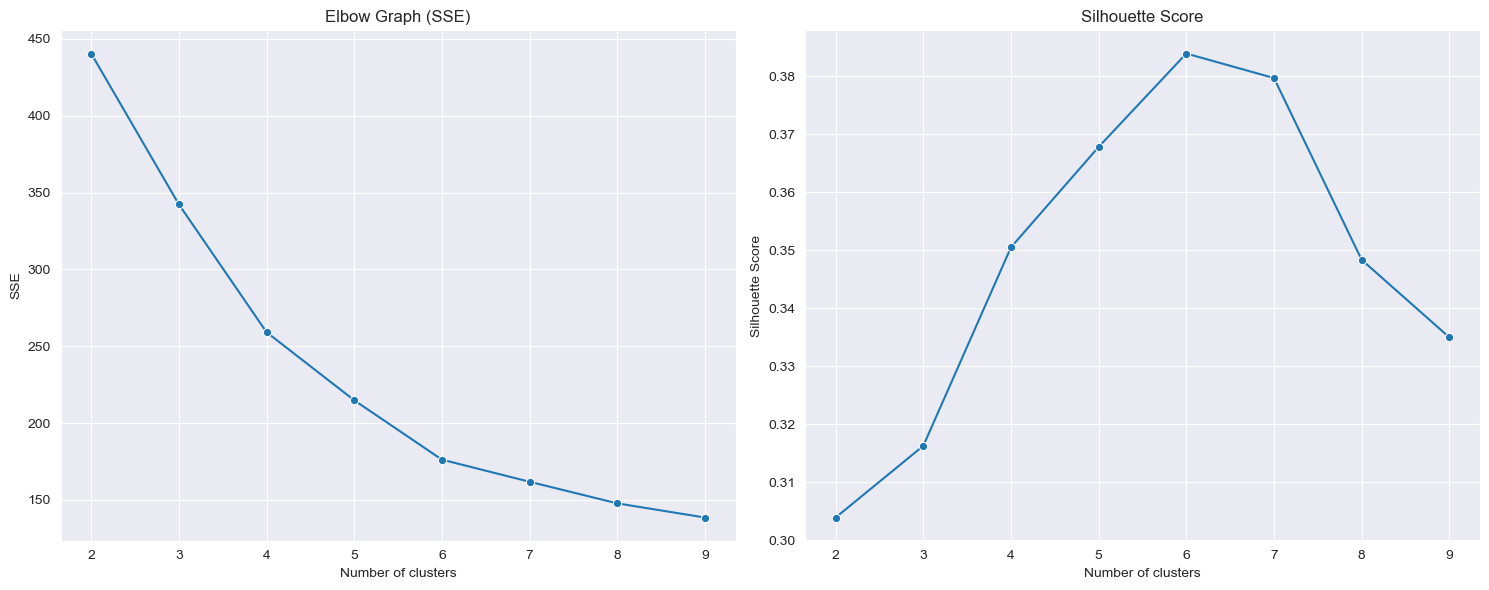

In [17]:
# Firstly we can start by obtaining the optimal K value for the K-Means algorithm
# We can do this by using the elbow method, which is a method of finding the optimal K value based on the sum of squared errors (SSE)
sse = []
sil_array = []

for no_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=no_cluster, random_state=0)
    kmeans.fit(initialdata)
    sse.append(kmeans.inertia_)
    sil_array.append(silhouette_score(initialdata, kmeans.labels_))


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the elbow graph
sns.lineplot(x=range(2, 10), y=sse, marker='o', ax=ax[0])
ax[0].set_title('Elbow Graph (SSE)')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('SSE')

# Plotting silhouette scores
sns.lineplot(x=range(2, 10), y=sil_array, marker='o', ax=ax[1])
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

#### Reading of elbow plot and optimal Silhoutte Score Graph

From the elbow graph, it can be said that **$K$=4** on the elbow graph is the "elbow" albiet a bit ambiguous, however we should consider that $K$ = 4 could be the optimal value for $K$, we can see that from the silhouette score plot $k$ = 6 seems to be the "optimal" k term, because of this contradiction, we can try a brute force method of guess and checking $K$ by looping through possible values of $K$ and taking the $K$ value which results in the best performance for the $K$ means clustering purely based off the statistics.

In [18]:
lst = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(initialdata)
    silhouette_avg = silhouette_score(initialdata, kmeans.labels_)
    db = davies_bouldin_score(initialdata, kmeans.labels_)
    ch = calinski_harabasz_score(initialdata, kmeans.labels_)
    lst.append([f'K = {k}', silhouette_avg, db, ch, 'K means'])
scoring_df.append(pd.DataFrame(lst, columns=['Params', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score', 'Model'])).sort_values(by='Silhouette Score', ascending=False)

,Model,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score,Params
4,K means,0.383907,0.983600,104.143649,K = 6
5,K means,0.379684,0.929382,96.888522,K = 7
3,K means,0.367813,0.993672,98.565480,K = 5
2,K means,0.350516,1.078788,98.349257,K = 4
6,K means,0.348359,1.066967,93.072046,K = 8
7,K means,0.334999,1.096272,87.995251,K = 9
9,K means,0.328798,1.059280,82.422630,K = 11
8,K means,0.328398,1.157215,86.516975,K = 10
11,K means,0.325434,1.100141,79.048633,K = 13
13,K means,0.325284,1.106491,76.264803,K = 15


### Evaluation of Optimal $K$ means
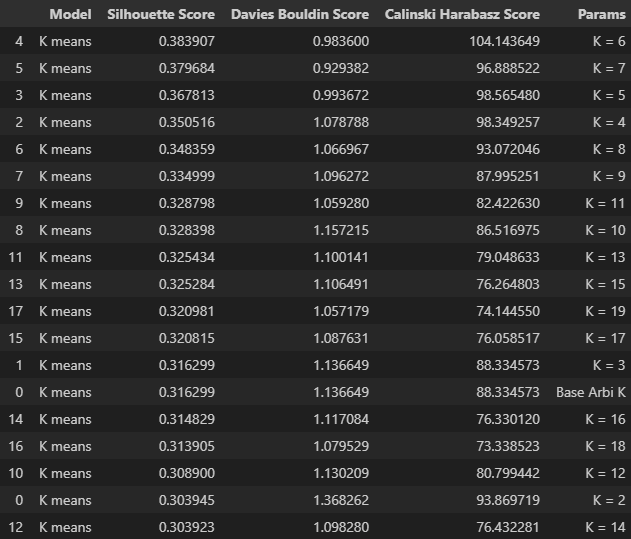

We can see that **$K$ = 6** provides the best Silhouette Score, with DB score on the lower end, as well as the highest CH score, it can be said that  $K$ = 6 is the optimal K value based off of $K$ means clustering. 


#### Assessment and Considerations:
Upon closer examination of the metrics, it's evident that while $K$ = 6 seems promising, there are certain limitations and potential for improvement:
The Silhouette Score of 0.38, though decent, suggests that there is room for enhancing the separation between clusters. This score indicates that some data points might be assigned to clusters where they don't fit perfectly. We can also see that most of the top performing models have K < 10, this makes sense as the dataset itself only has 200 entries and it wouldnt make sense to have more than 10 clusters, with each cluster having less than 20 people on average, they cant really be defined as a cluster. due to this i will be considering less k terms for future tuning to be more efficient.

## Enhancing Clustering Results through Advanced Techniques and Hyperparameter Tuning

When aiming to achieve superior clustering results, it's valuable to explore alternative clustering models beyond the conventional K-means algorithm. 
### Exploring Alternative Clustering Models

1. **Agglomerative Clustering**: A type of hierarchical clustering, agglomerative clustering builds a hierarchy of clusters. Starting with individual data points as clusters, it iteratively merges clusters based on certain linkage criteria (e.g., Ward, complete, average linkage). This method can reveal insights into both small and large-scale structures within the data.

2. **Spectral Clustering**: Spectral clustering takes advantage of the eigenvalues and eigenvectors of a similarity matrix derived from the data. It transforms the data into a lower-dimensional space, where traditional clustering methods like K-means can be applied. Spectral clustering is effective for datasets with complex structures and non-convex clusters.

3. **Affinity Propagation**: Unlike the other models, affinity propagation does not require specifying the number of clusters beforehand. It operates by sending messages between data points, determining which points should be exemplars (representatives) of clusters. This approach can identify clusters of varying sizes and shapes, making it suitable for a wide range of data patterns.





In [19]:
# initiate all the new models and fit them to the "Optimal K" from k means

models = {
    "Hierarchical Clustering": AgglomerativeClustering(),
    "Spectral Clustering": SpectralClustering(random_state=0),
    "Affinity Propagation": AffinityPropagation(random_state=0)
}


In [20]:
lst = []

for model_name, model in models.items():
    model.n_clusters = 6 # Note that 13 is not actually the optimal K for all these models, and in this case we are using it as a base
    model.fit(X = initialdata)
    silhouette = silhouette_score(initialdata, model.labels_)
    db_Score = davies_bouldin_score(initialdata, model.labels_)
    calinski = calinski_harabasz_score(initialdata, model.labels_)
    lst.append([model_name, silhouette, db_Score, calinski, '"Optimal K" From K means'])

scoring_df = scoring_df.append(pd.DataFrame(lst, columns=['Model', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score', 'Params']))

## Alternative Models Evaluation and Considerations (Model Improvement)

Recall how each scoring criteria works,

Silhouette Score:


The Silhouette Score measures how similar each data point in a cluster is to the other points in the same cluster compared to the nearest neighboring cluster. **Higher** Silhouette Scores indicate better-defined and well-separated clusters.

Davies Bouldin Score:


The Davies Bouldin Score measures the average similarity between each cluster and its most similar cluster. **Lower** Davies Bouldin Scores indicate better clustering results with more distinct clusters.

Calinski Harabasz Score:


The Calinski Harabasz Score is a ratio of between-cluster variance to within-cluster variance. **Higher** Calinski Harabasz Scores suggest well-separated clusters.

Let's compare the models' performance:

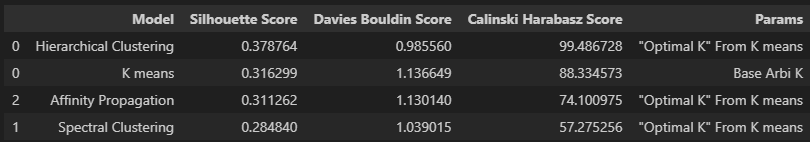

Before the evaluation, let me discuss the Params column. The param column states **"Optimal "$K$" From K means** for all of the new models, do note that these might not be the actual Optimal K for these new models and i am just using the $K$ value obtained previously as a placeholder $K$ value. Now for the actual evaluation, It can be said that **Hierarchical Clustering** as well as **K means** can be said to be the best performing models solely based of the scores, (Hierarchical best scores in Silhouette as well as CH index, Spectral Clustering best scores for DB index), however the other models cannot be neglected as the $K$ value currently used might be hindering their performance.

### The Path Ahead
To further improve the models and to eventually find the "best" model as well as the most accurate clusters, we can consider these following steps:


1. **Feature Selection** Although it is already a bit late in the clustering report, feature selection should still be considered in order to try and maximize the performance of the models and generate more quality clustering.
2. **Optimal K Tuning**, we can brute force to get the optimal K term for each model


## Feature Selection

To find the best way to group people based on their age, income, and spending, we can try different combinations of these factors. We want to make clusters where similar people are together.

We use two things to see which combination is best:

1. Elbow Method: This helps us find the point where clusters stop getting much better. It's like finding the best way to group them that makes the most sense.

2. Silhouette Score: This checks how well the people fit into their clusters. If they fit nicely with others in the same group and not so well with people in other groups, it's a good sign.

In [21]:
features_sets = chain(combinations(initialdata.columns, 3), combinations(initialdata.columns, 4)) # get every combination of 3 and 4 features

temp = []

for features in features_sets:
    for k in range(2, 10):
        kmean = KMeans(n_clusters = k, random_state=0)
        cluster_labels = kmean.fit_predict(initialdata[list(features)])
        inertia = kmean.inertia_
        labels = cluster_labels
        silhouettes_avg = silhouette_score(initialdata, cluster_labels)
        
        temp.append([features, k, inertia, silhouettes_avg])


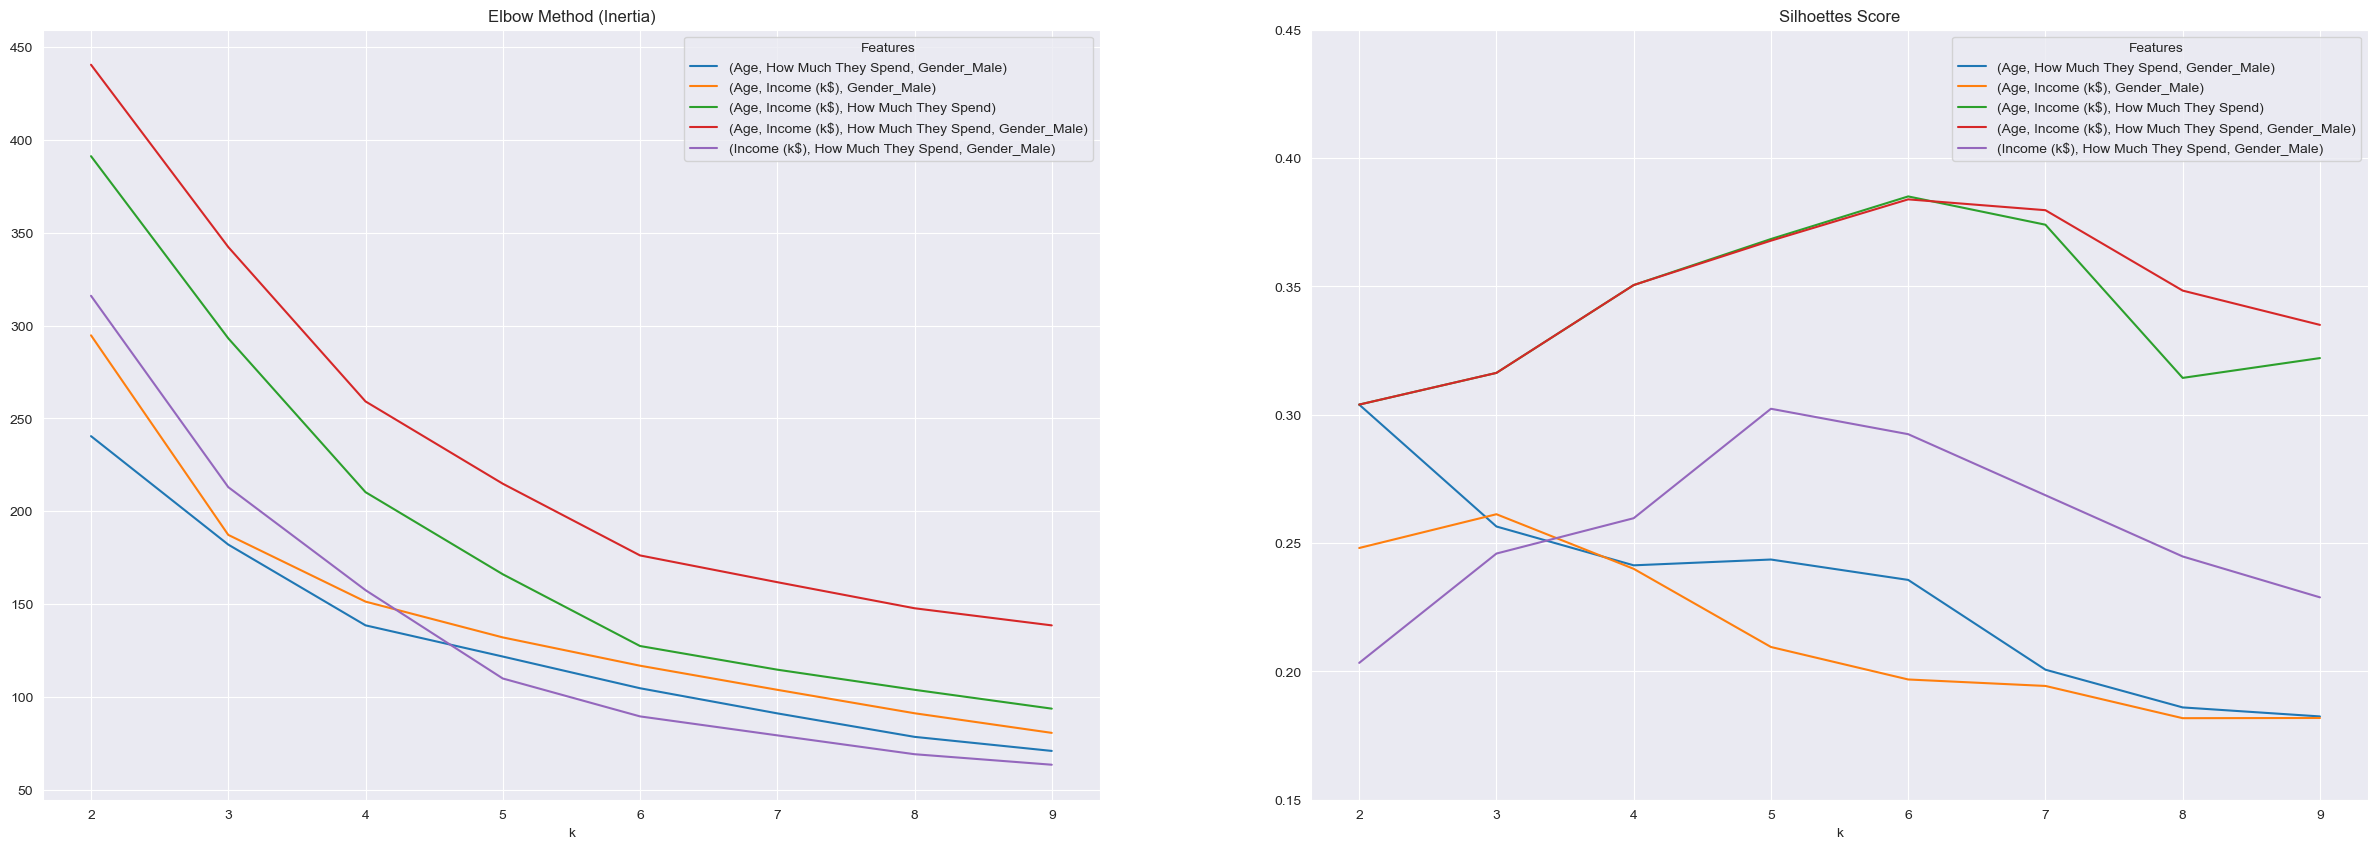

In [22]:
records_df = pd.DataFrame(temp, columns=['Features', 'k', 'Inertia', 'Silhoettes_Avg']).set_index("Features") # Saving history to dataframe
silhoettes_pivot = records_df.pivot_table(values = 'Silhoettes_Avg', index='k', columns='Features') 
inertia_pivot = records_df.pivot_table(values = 'Inertia', index='k', columns='Features')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

inertia_pivot.plot(ax = ax1)
ax1.set_title("Elbow Method (Inertia)")

silhoettes_pivot.plot(ax=ax2)
ax2.set_title("Silhoettes Score")
ax2.set_ylim(0.15, 0.45) # Set y lim to make legend more visible

plt.show()

### Feature Selection Evaluation


**Elbow Plot:**
Looking at the elbow plot, we can use the red line as a base (all features), we can see that the green line has a nearly identical shape, this shows that removing the gender column will have almost no effect on the clustering.

**Silhouettes Score:**
Based off the silhouette score we notic the same thing with the red and green line basically overlapping over each other, removing the gender column will have close to no effect on the clustering.


**Evaluation:**
Recall the previous pairplot, 


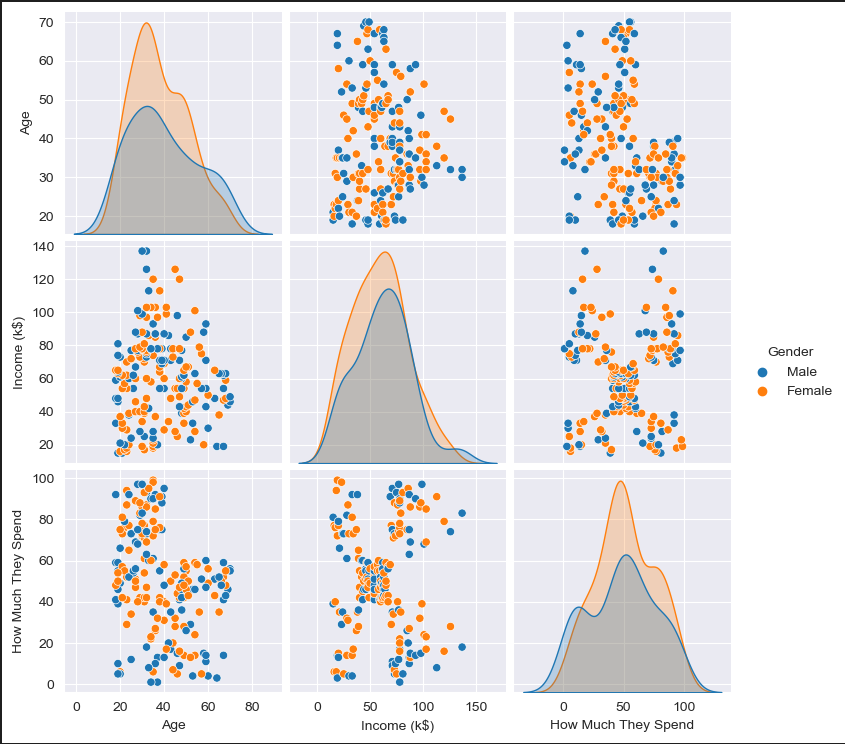

we recall that the distribution of the data seems random across each feature, there is close to no recognizable pattern or clustering based off of gender, it is safe to say that removing the gender column will have close to no effect on the clustering, this will allow us to have an easier time with the visualization of the clustering. 

In [23]:
#remove the gender column 

selecteddata = initialdata.drop(columns="Gender_Male")

## Tuning of other models

As a start, we can first get the K value which gives the best performance for each model. This can be done using simple iterations.

### K tuning


We can tune the optimal K for each model

In [24]:
#Tuning
lst = []

for model_name, model in models.items():
    for k in range(2, 10):
        model.n_clusters = k 
        model.fit(X = selecteddata)
        silhouette = silhouette_score(selecteddata, model.labels_)
        db_Score = davies_bouldin_score(selecteddata, model.labels_)
        calinski = calinski_harabasz_score(selecteddata, model.labels_)
        lst.append([model_name, silhouette, db_Score, calinski, f'K = {k}'])

scoring_df = scoring_df.append(pd.DataFrame(lst, columns=['Model', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score', 'Params']))

In [25]:
#top 10 models
scoring_df.sort_values(by='Silhouette Score', ascending=False).head(10)

,Model,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score,Params
4,Hierarchical Clustering,0.444345,0.821326,133.932034,K = 6
5,Hierarchical Clustering,0.439242,0.774687,127.210223,K = 7
13,Spectral Clustering,0.430685,0.754060,118.891271,K = 7
12,Spectral Clustering,0.428631,0.793070,122.656374,K = 6
14,Spectral Clustering,0.424726,0.764415,113.433925,K = 8
3,Hierarchical Clustering,0.411975,0.886666,112.343402,K = 5
11,Spectral Clustering,0.408303,0.867553,113.715627,K = 5
15,Spectral Clustering,0.404947,0.730562,102.658352,K = 9
7,Hierarchical Clustering,0.397862,0.821954,122.344038,K = 9
10,Spectral Clustering,0.394653,0.956019,113.548912,K = 4


##### K Tuning Evaluation

We can see that Hierarchical Clustering with $K$ = 6 , has the highest Silhouette Score and the highest Calinski Harabasz Score, with a respectful Dabies Bouldin Score. However we should make the final evaluation after visualizing the actual clustering as the scores might be misleading. For this visualization, i will also be consider the Spectral Clustering model with $k$ = 7 with respectable Silhouette Score, Calinski Harabasz Score as well as one of the highest Davies Bouldin Scores. 


However, this is not the limit of model improvement, we can try to further tune parameters besides the n_cluster. Due to how the top 10 results are all spectral clustering and hierarchical clustering models, i will only be tuning these 2 in order to save computing resources.

### Grid Search Hyperparameter tuning

By performing this systematic selection of parameters for various clustering algorithms and their parameter settings, we will be able to find the most suitable algorithm and parameter configuration for clustering the given dataset effectively. The following code will loop through a list of models and their corresponding parameters and fit it to the data and evaluate them accordingly.

In [26]:

# Define the list of models with their respective grids
tunable = [
    {
        'model': SpectralClustering(random_state = 0),
        'grid': {
            'eigen_solver': ['arpack', 'lobpcg'],
            'n_components': [5, 10, 20, None],
            'affinity': ['nearest_neighbors', 'rbf'],
            'n_neighbors': [2, 5, 10],
            'assign_labels': ['kmeans', 'discretize', 'cluster_qr']
        }
    },
    {
        'model': AgglomerativeClustering(),
        'grid': {
            'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
                        'manhattan', 'braycurtis', 'canberra', 'chebyshev', 
                        'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 
                        'minkowski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 
                        'sokalsneath', 'sqeuclidean', 'yule'],
            'linkage': ['complete', 'average', 'single']
        }
    }
]


# Loop through each model and its grid
for n_cluster in range(2, 10):
    for model_set in tunable:
        model = model_set['model']
        grid = model_set['grid']
        param_combinations = list(itertools.product(*grid.values()))

        lst = []
        for params in param_combinations:
            param4model = dict(zip(grid.keys(), params))
            param4model['n_clusters'] = n_cluster
            model_set = model.set_params(**param4model)
            model_set.fit(selecteddata)
            silhouette = silhouette_score(selecteddata, model_set.labels_)
            db_score = davies_bouldin_score(selecteddata, model_set.labels_)
            ch_score = calinski_harabasz_score(selecteddata, model_set.labels_)
            lst.append([model, silhouette, db_score, ch_score, param4model])

        scoring_df = scoring_df.append(pd.DataFrame(lst, columns=['Model', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score', 'Params']))



In [27]:
scoring_df.sort_values(by='Silhouette Score', ascending=False).head(3)

,Model,Silhouette Score,Davies Bouldin Score,Calinski Harabasz Score,Params
64,"SpectralClustering(assign_labels='cluster_qr',...",0.458001,0.809001,143.039121,"{'eigen_solver': 'arpack', 'n_components': Non..."
67,"SpectralClustering(assign_labels='cluster_qr',...",0.458001,0.809001,143.039121,"{'eigen_solver': 'arpack', 'n_components': Non..."
70,"SpectralClustering(assign_labels='cluster_qr',...",0.458001,0.809001,143.039121,"{'eigen_solver': 'arpack', 'n_components': Non..."


#### Grid Search Evaluation

Highest Silhouette Score:


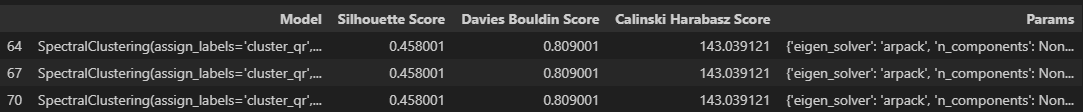


Calinski Harabasz Score:


!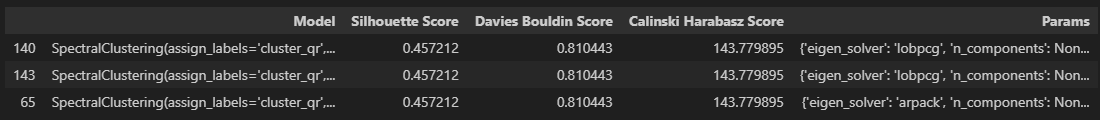


Based off the Silhouette Score and the Calinski Harabasz Score, we can choose two suitable models for comparison to select the final model. If you are wondering why i didnt pick a model based off of Davies Boulding Score, it is because out of the models with the highest DB score, there appears to be many anomalies.

## Visualization of models

We can use a scatterplot to visualize the clustering in each feature

Text(0.5, 1.0, 'Income (k$) against How Much They Spend')

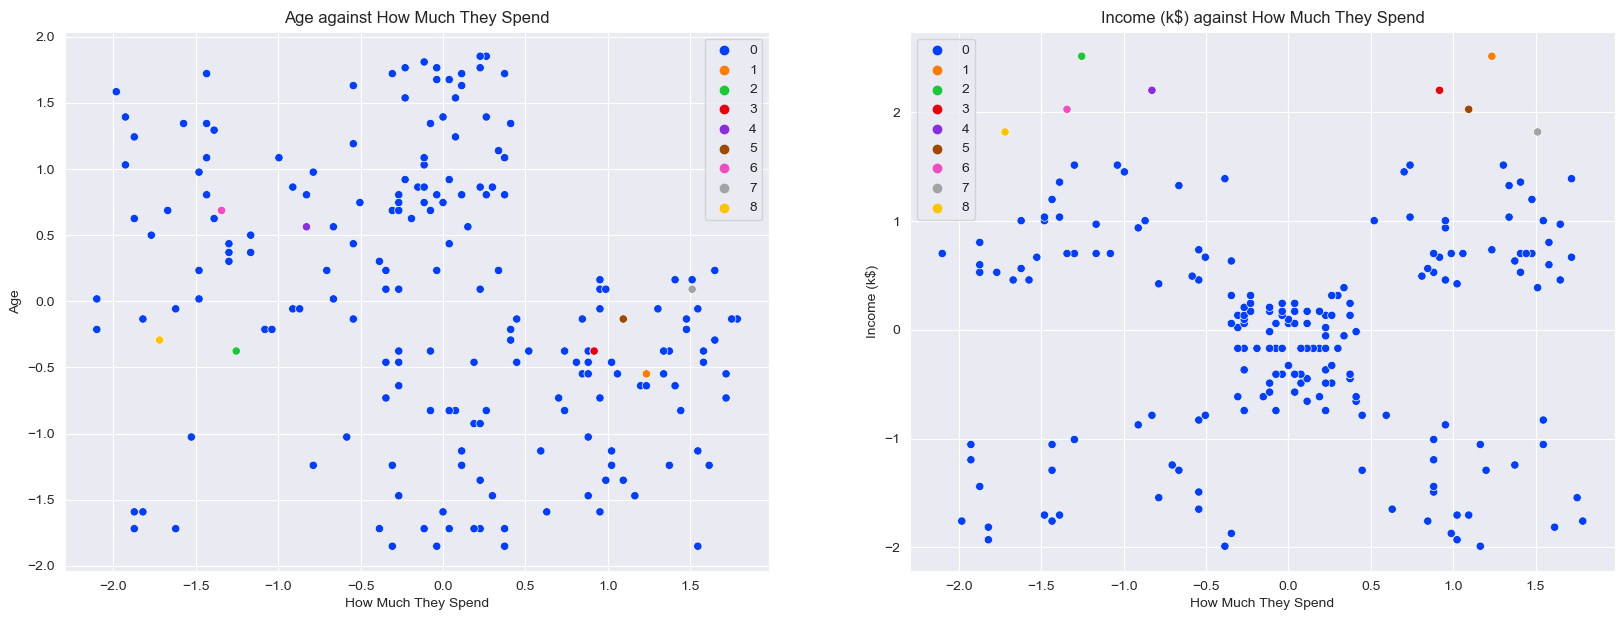

In [28]:

model = scoring_df.sort_values(by='Calinski Harabasz Score', ascending=True).reset_index(drop=True).iloc[0]['Model'] 
model.fit(selecteddata)
labels = model.labels_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7))
sns.scatterplot(x = 'How Much They Spend', y='Age', hue = labels, palette = 'bright' , data = initialdata, ax = ax1)
ax1.set_title("Age against How Much They Spend")

# Plotting Annual Income (k$) against Spending Score (1-100)
sns.scatterplot(x = 'How Much They Spend', y='Income (k$)', hue = labels, palette = 'bright', data = initialdata, ax = ax2)
ax2.set_title("Income (k$) against How Much They Spend")

Text(0.5, 1.0, 'Income (k$) against How Much They Spend')

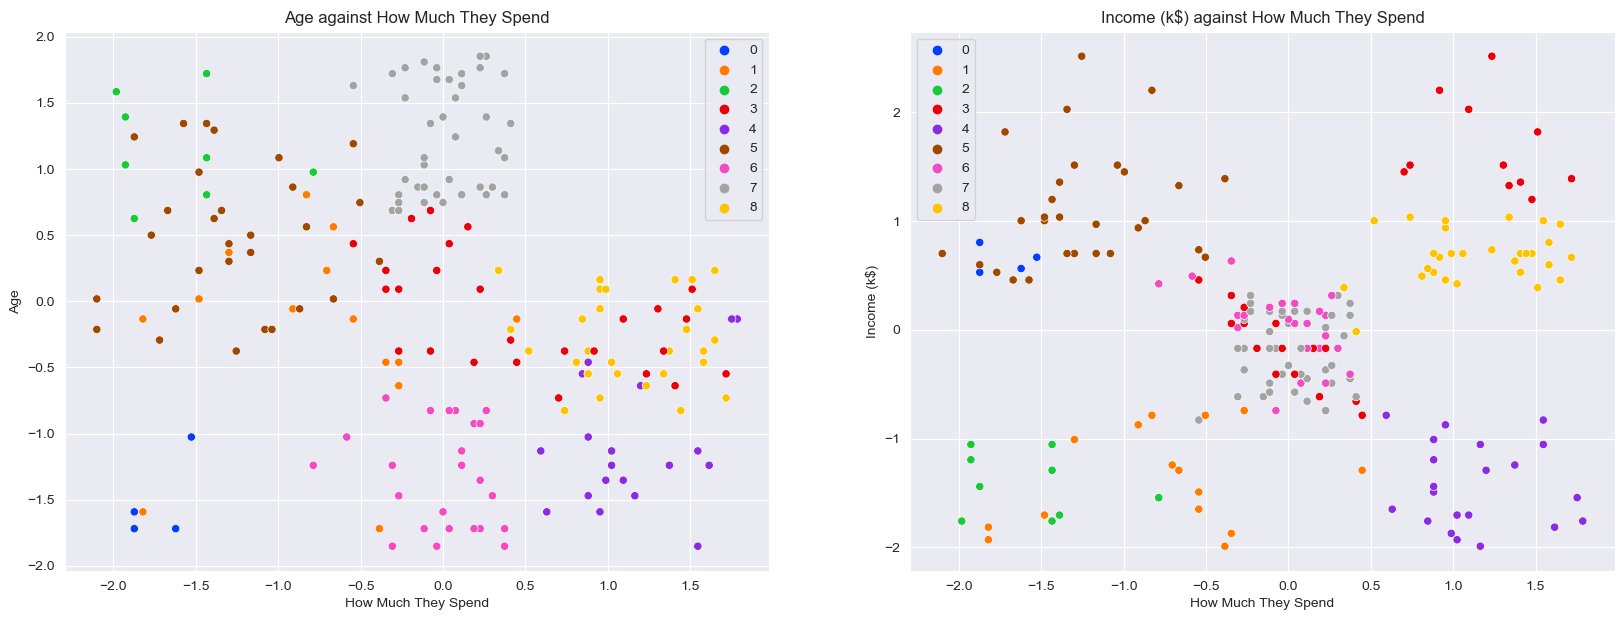

In [29]:
model = scoring_df.sort_values(by='Silhouette Score', ascending=False).reset_index(drop=True).iloc[0]['Model'] 
model.fit(selecteddata)
labels = model.labels_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7))
sns.scatterplot(x = 'How Much They Spend', y='Age', hue = labels, palette = 'bright' , data = initialdata, ax = ax1)
ax1.set_title("Age against How Much They Spend")

# Plotting Annual Income (k$) against Spending Score (1-100)
sns.scatterplot(x = 'How Much They Spend', y='Income (k$)', hue = labels, palette = 'bright', data = initialdata, ax = ax2)
ax2.set_title("Income (k$) against How Much They Spend")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


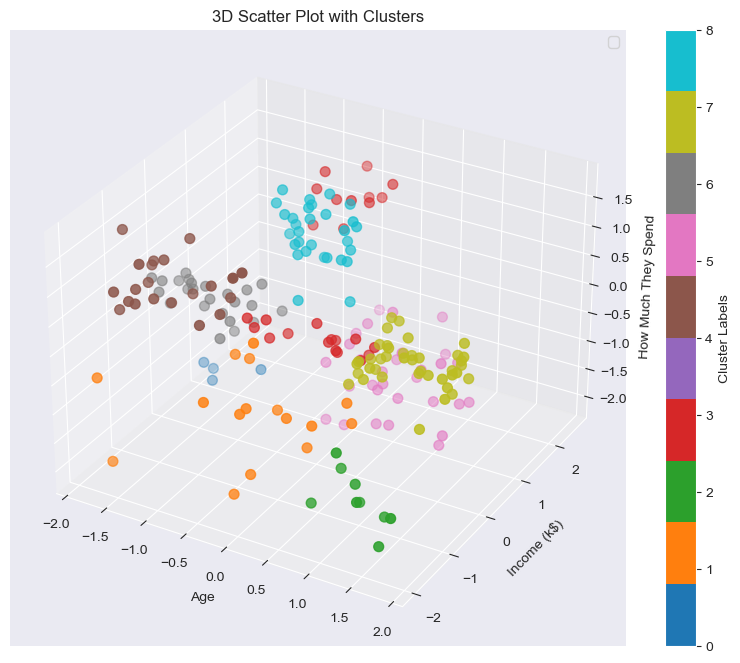

In [30]:
# %matplotlib tk
# uncomment top line for 3d scatter that is interactive


fig = plt.figure(figsize=(10, 8))
ax_3d = fig.add_subplot(projection='3d')

#Data points
x = initialdata['Age']
y = initialdata['Income (k$)']
z = initialdata['How Much They Spend']  # Gender data as the Z-axis
labels = labels


scatter = ax_3d.scatter(x, y, z, c=labels, cmap='tab10', s=50)
ax_3d.set_xlabel('Age')
ax_3d.set_ylabel('Income (k$)')
ax_3d.set_zlabel('How Much They Spend')
ax_3d.set_title('3D Scatter Plot with Clusters')


fig.colorbar(scatter, ax=ax_3d, label='Cluster Labels')
ax_3d.legend()
plt.show()

# Final Evaluation

Visually, we can see that there is something wrong with the model with the highest CH score, therefore for the final clustering i will just be using the model with the highest Silhouette Score, which is SpectralClustering(assign_labels='cluster_qr', eigen_solver='lobpcg', n_clusters=9, random_state=0)

In [31]:
selecteddata['label'] = labels

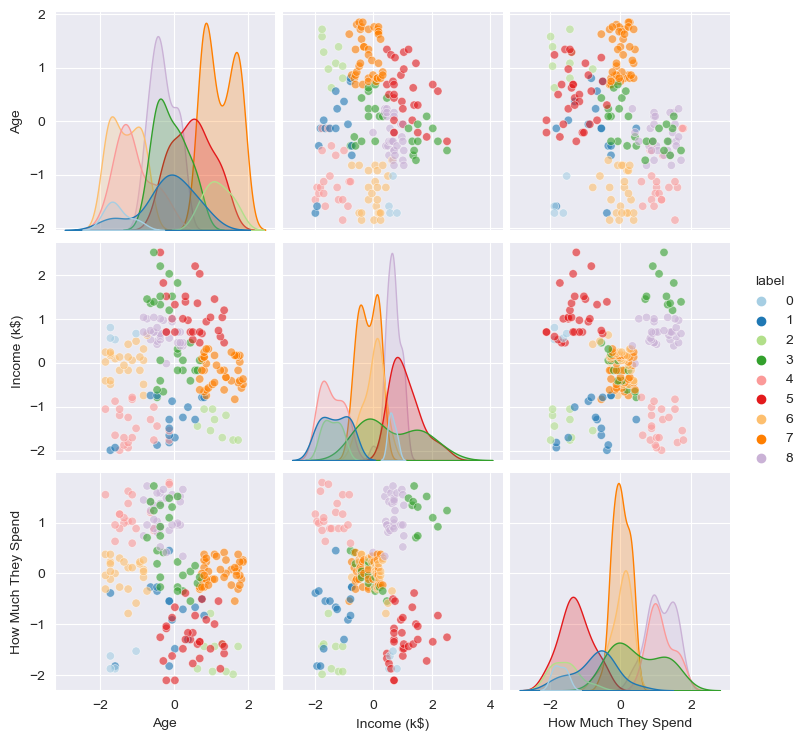

In [32]:
sns.pairplot(selecteddata, hue = 'label', palette = 'Paired', plot_kws=dict(alpha=0.6)) # add alpha to opacity because of overlappign clusters
plt.show()

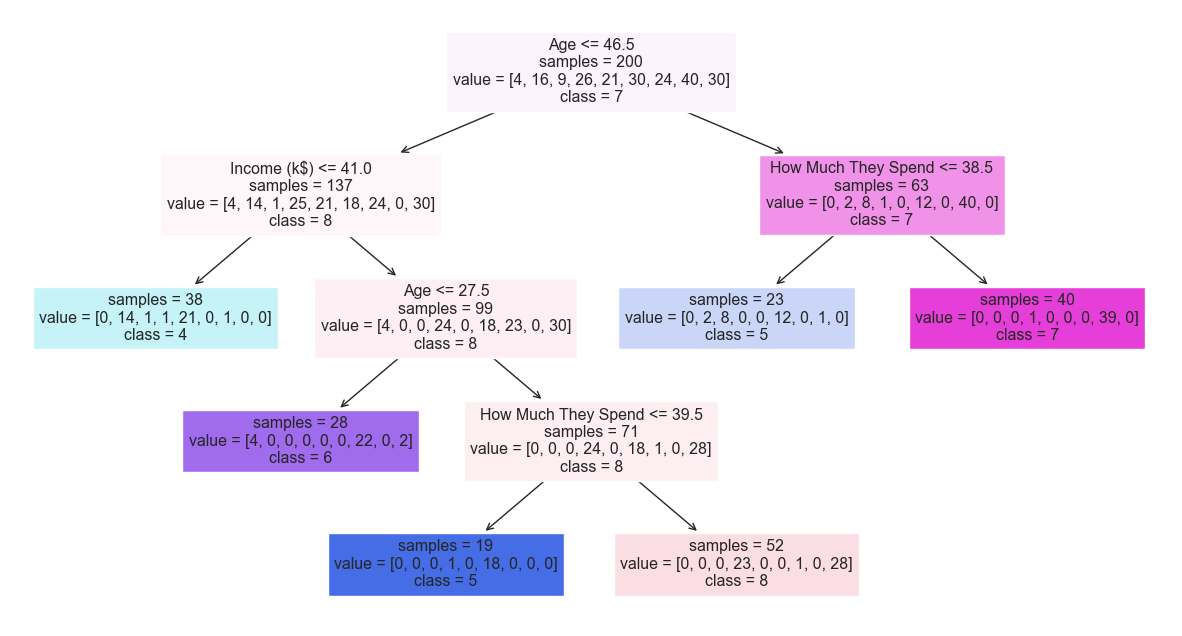

In [38]:
#idea referenced from https://observablehq.com/@andrew-qu2000/surrogate-decision-trees
#implementation inspired by https://stackoverflow.com/questions/70274387/sklearn-plot-tree-how-to-visualize-class-labels-for-classification-task

initialdata = pd.read_csv('data/Customer_Dataset.csv')
initialdata['label'] = labels
initialdata.drop(columns=['CustomerID', 'Gender'], inplace=True)
dtc = DecisionTreeClassifier(max_leaf_nodes=6) 

dtc.fit(initialdata.drop(columns='label'), initialdata['label']) #learn how labels are fitted based off of  data

fig, ax = plt.subplots()
plot_tree(
            dtc,
            feature_names = initialdata.drop(columns='label').columns,
            class_names= np.unique(selecteddata['label'].values.astype(str)),
            impurity=False,
            filled = True, 
            ax = ax, 
            )
plt.show()

In [34]:
initialdata.groupby('label').mean().T

label,0,1,2,3,4,5,6,7,8
Age,20.75,35.4375,55.888889,35.923077,24.809524,44.433333,22.458333,57.450,33.066667
Income (k$),76.25,27.8125,25.555556,77.230769,25.619048,90.400000,58.958333,53.675,77.066667
How Much They Spend,8.00,30.5625,11.333333,62.615385,80.238095,17.933333,49.000000,49.475,80.366667


In [35]:
initialdata.groupby('label').count().T

label,0,1,2,3,4,5,6,7,8
Age,4,16,9,26,21,30,24,40,30
Income (k$),4,16,9,26,21,30,24,40,30
How Much They Spend,4,16,9,26,21,30,24,40,30


## Interpretation of the decision tree

he 'value' section in each node displays the distribution of target class labels. It shows the count of samples from each class(label/cluster) in that node. Model fits the labels as a class that fits their attributes the most. For the splits, left means that it fits the conditon, right means that it doesnt fit the condition

<!-- ### Identifying and Profiling Each Cluster


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 0:**
Class 0 represents individuals with a younger age, moderate spending score, and a moderate income. These individuals can be characterized as young people who have just started working. They account for **35 out of 200** in the total customer demographic, ranking in at **3rd** place.

`Eg. Depiction of Truman from The Truman Show`

- To encourage more spending from this group, consider using **Offers and Discounts**. These individuals, who tend to be somewhat cautious with their spending, are often attracted to opportunities for saving money.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 1:**
Class 1 consists of individuals with an older age, moderate income, and a moderate spending score. They can be associated with the persona of **"Aunties/Uncles"**. This class makes up **52 out of 200** in the customer demographic, the **largest** among all the classes, making them a crucial target for marketing.


`Eg. Average class Singaporean Aunties/Uncles`


- As this is the primary group to focus on, it's important to strike a balance to encourage more spending. Additionally, when catering to other customers, it's essential not to compromise on accommodating this group. Older individuals, especially in Singapore, are prudent with their spending. Convincing them may require emphasizing product quality. Consider showcasing the durability, craftsmanship, and reliability of the products sold in the store.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 2:**
Class 2 comprises customers with high spending scores and incomes, but with a low age. These individuals can be classified as **Successful Young Businessmen/Women**. Their relatively high income at a young age might contribute to their elevated spending score. This class makes up a notable **39 out of 200** of the customers and ranks as the **2nd** most prominent group.


`Eg. The guy from wolf of wallstreet`

- A potential marketing approach for this segment is to highlight luxury and exclusivity. Create campaigns that revolve around the concept of indulging in premium experiences. Showcase the unique features and benefits of high-end products. Consider organizing events, workshops, or VIP experiences to make these customers feel valued and special. Leverage social media and influencers to generate excitement around your brand.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 3:**
Class 3 customers are older, possess the highest income among the groups, but exhibit a low spending score. They can be described as **Stingy but Affluent Uncles and Aunties**. Comprising **31 out of 200** in the total customer demographic, they rank in at **4th** place.


`Eg. Mr krabs from spongebob`


- This group should be a top priority as they have significant spending potential despite their low spending score. To increase sales among these cost-conscious customers, consider offering discounts on items. Stingy individuals are often enticed by opportunities to save money. However, this preliminary assessment highlights the need for a more in-depth analysis to cater to this group effectively.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 4:**
Class 4 customers are older in age, have low income, and exhibit a low spending score. They are representative of **Low-Income Families**. This class accounts for **22 out of 200** in the total customer demographic, ranking in at **5th** place.


`Eg. Maybe something like the poor family from parasite (2019)`


- For this group, the focus should be on assisting rather than maximizing profits. Affordable and practical items are a wise choice. Position products as essential items that provide value without straining their limited budget.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**Class 5:**
Class 5 consists of individuals with a low age, low income, but a high spending score. These customers fit the typical **Teenager** persona. Despite their low income, these individuals often overspend due to inexperience and impulsiveness. They comprise **22 out of 200** in the total customer demographic, ranking them last.


`Eg. Sean See Shao En`


- Marketing towards this group requires tapping into their desire for self-expression and trends. Offer trendy items that are considered "cool" among teenagers, such as sneakers associated with ["Dr!p"](https://www.urbandictionary.com/define.php?term=drip) culture. Another effective option is game gift cards, catering to their engagement with gaming culture. Since parents often disapprove of spending on games, offering these cards can significantly boost their spending score. Gift cards come with minimal production costs, making them an opportunity to capitalize on teenage spending tendencies. Consider offering cards for games like Valorant, Roblox, and Fortnite. -->


### Customer Cluster Profiling/Makerting techniques
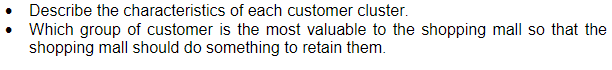

---

#### Cluster 0: Young and Cautious

**Description:** Individuals in this cluster are relatively young and cautious spenders despite their decently high income.

**Example Persona:** Leonard From "Big bang Theory"

**Marketing Approach:** Emphasize affordability and discounts to attract cautious spenders. We can consider promoting cost-effective essentials and targeting students.

---

#### Cluster 1: Middle-Aged Bargain Seekers

**Description:** Cluster 1 consists of middle-aged individuals who prioritize practical spending and have low income.

**Example Persona:** Frank Gallagher from "Shameless"

**Marketing Approach:** Highlight practicality and value for money. Offer bundle deals and emphasize the durability and practicality of products to market more towards this group,However we should not be focusing much on this group due to their low spending power.

---

#### Cluster 2: Seasoned Savers

**Description:** Individuals in Cluster 2 are older with lower income and prioritize frugal spending.

**Example Persona:** The Father from "Parasite" (2019)

**Marketing Approach:** Focus on long-term savings and durability. Offer timeless products with long lifespans to resonate with the frugal mindset of this group, although i discourage trying to market towards these older people of low income.

---

#### Cluster 3: Affluent Spenders

**Description:** Cluster 3 includes middle aged individuals with high incomes and upper middle classed spendings.

**Example Persona:** The father from "Gilmore Girls"

**Marketing Approach:** This group of individual's high income but moderate spending shows that they do not seek luxury. A good way to target this group of individuals in marketing is by advertising more products that provide lifestyle enhancements in the form of comfort or convenience.

---

#### Cluster 4: Youthful Experiencers/Trendy Youths

**Description:** Individuals in Cluster 4 are young and exhibit lavish spending behaviors despite their low incomes.

**Example Persona:** My classmate, Sean See Shao en

**Marketing Approach:** Marketing towards this group requires tapping into their desire for self-expression and trends. Offer trendy items that are considered "cool" among teenagers, such as sneakers associated with ["Dr!p"](https://www.urbandictionary.com/define.php?term=drip) culture. Another effective option is game gift cards, catering to their engagement with gaming culture. Since parents often disapprove of spending on games, offering these cards can significantly boost their spending score. Gift cards come with minimal production costs, making them an opportunity to capitalize on teenage spending tendencies. Consider offering cards for games like Valorant, Roblox, and Fortnite..

---

#### Cluster 5: Stingy Buyers

**Description:** Cluster 5 comprises older individuals with higher incomes but extremely stingy spendings.

**Example Persona:** Mr Krabs from Spongebob

**Marketing Approach:** This group should be a top priority as they have significant spending potential despite their low spending score. To increase sales among these cost-conscious customers, consider offering discounts on items. Stingy individuals are often enticed by opportunities to save money. However, this preliminary assessment highlights the need for a more in-depth analysis to cater to this group effectively.

---

#### Cluster 6: Young Professionals

**Description:** Individuals in Cluster 6 are young professionals with moderate incomes and moderate spendings.

**Example Persona:** Leslie from "Parks and Recreation."

**Marketing Approach:** Promote versatility and style. Offer products suitable for both professional and casual settings, targeting the lifestyle and aspirations of young professionals. As these individuals might be new to the working world and might be looking to be more independent, it might be wise to sell more furniture/housing items that they might need for their newly bought BTO flat/ rented apartment.

---

#### Cluster 7: Mature and smart shoppers

**Description:** Cluster 7 consists of older individuals with moderate incomes and moderate spending habits.

**Example Persona:** Uncle Iroh from "Avatar"
**Marketing Approach:** This group of individuals have spending habits that match their income, as they are on the older end they are likely to be more knowledgable when spending money, it will be hard to encourage more spending amongst this group but it is possible, provided more analysis on their habits and likes.

---

#### Cluster 8: Successful young entrepreneurs

**Description:** Individuals in Cluster 8 are young with high incomes and extravagant spending habits.

**Example Persona:** The Patrick Bateman from "American Psycho"

**Marketing Approach:** A potential marketing approach for this segment is to highlight luxury and exclusivity. Create campaigns that revolve around the concept of indulging in premium experiences. Showcase the unique features and benefits of high-end products. Consider organizing events, workshops, or VIP experiences to make these customers feel valued and special. Leverage social media and influencers to generate excitement around your brand. As this group of individuals tend to be more egotistical, it is good to offer them "luxury" or "premium" products and experiences to allow them to feel that they are better than others.

---


Retaining Valuable Customers

---

**Count for each demographic of customer out of 200 customers:**


|        **Label**          | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
|------------------|---|---|---|---|---|---|---|---|---|
| **Count**          | 9 | 24| 20| 39| 16| 17| 22| 29| 24|



From this Table, we can roughly understand the demographic of the customers, we can pick out the top 3 groups of customers as they make up over half of the total customer demographic. So these groups will be cluster 8, 7 as well as 5. The most prominent group out of the 3 will be group 8, however as previously stated it will be hard to encourage them to spend more, and they can be said to be in a stable position as a group that we do not risk losing. However, group 5 which has high spending power, but low spending score could be said to be a group that we are at risk of losing. Because of their frugality, they might resort to other cheaper alternatives for shopping and their other neccessities, however we can entice them by offering bundles and discounts in an attempt to draw out more spendign and retain these customers.


References:

["https://www.mathworks.com/help/matlab/visualize/visualizing-four-dimensional-data.html"](https://www.mathworks.com/help/matlab/visualize/visualizing-four-dimensional-data.html)


["https://stats.stackexchange.com/questions/5774/can-principal-component-analysis-be-applied-to-datasets-containing-a-mix-of-cont"](https://stats.stackexchange.com/questions/5774/can-principal-component-analysis-be-applied-to-datasets-containing-a-mix-of-cont)